In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.gridspec as gridspec 

import missingno as ms
pd.set_option('display.max_columns',None)

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

import warnings
warnings.filterwarnings('ignore')

In [2]:
churns = train[train['CHURN'] == 1]
no_churns = train[train['CHURN'] == 0]

In [3]:
#ms.matrix(churns)

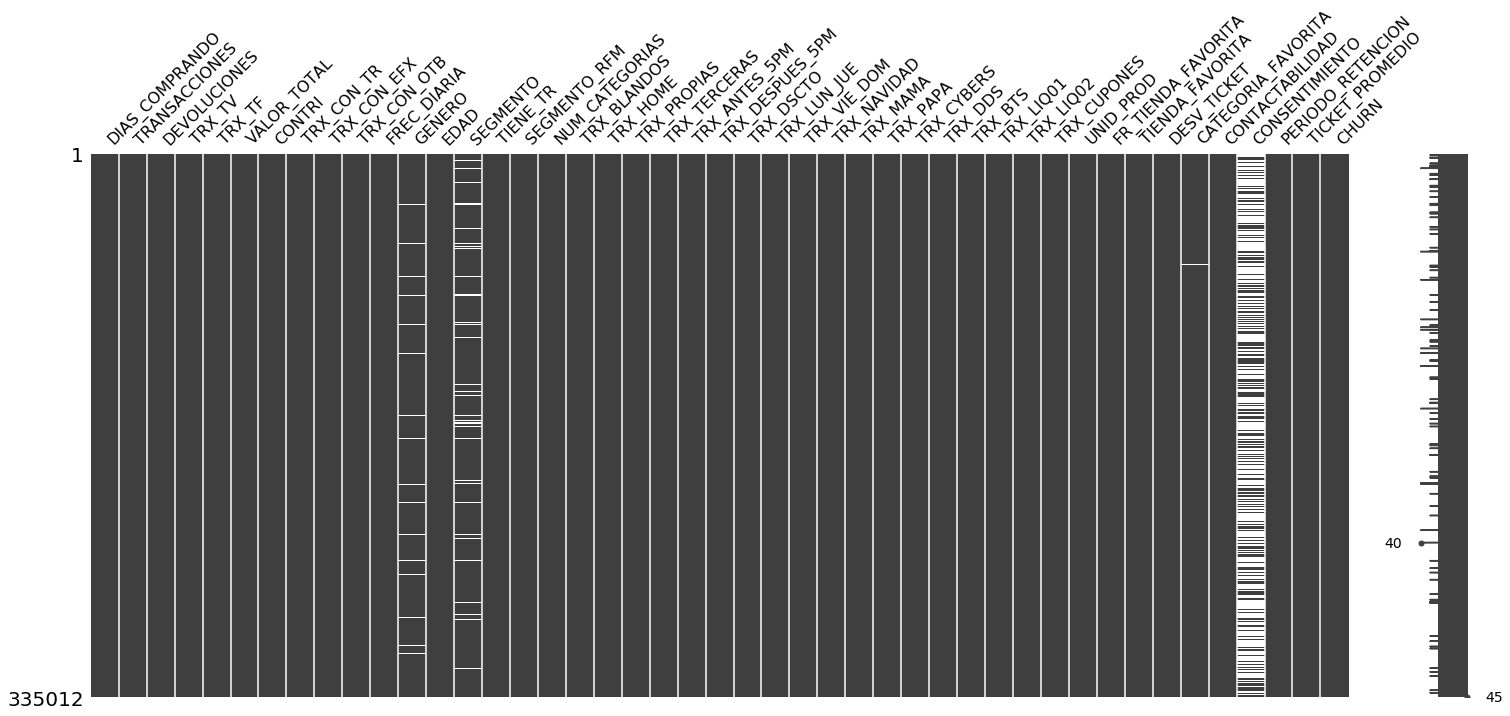

In [4]:
ms.matrix(no_churns)

### Respondiendo a mis preguntas

Los que tienen a fugar son en sí los que contribuyen algo menos y tienen un valor total menor de compra.

In [5]:
# Los no-churns tienden a dar más dinero!!! 

print('Media del valor total de los churns',churns.VALOR_TOTAL.mean())
print('Media de las contribuciones de los churns',churns.CONTRI.mean())
print('Media del valor total de los no churns',no_churns.VALOR_TOTAL.mean())
print('Media de las contribuciones de los no churns',no_churns.CONTRI.mean())

Media del valor total de los churns 250.54388258373868
Media de las contribuciones de los churns 47.82816663977242
Media del valor total de los no churns 950.7663281994862
Media de las contribuciones de los no churns 187.85231761847


In [6]:
def print_quantiles(df):
    print(df.quantile(.10),'--->10')
    print(df.quantile(.15),'--->15')
    print(df.quantile(.20),'--->20')
    print(df.quantile(.25),'--->25')
    print(df.quantile(.30),'--->30')
    print(df.quantile(.35),'--->35')
    print(df.quantile(.40),'--->40')
    print(df.quantile(.45),'--->45')
    print(df.quantile(.50),'--->50')
    print(df.quantile(.60),'--->60')
    print(df.quantile(.70),'--->70')
    print(df.quantile(.75),'--->75')
    print(df.quantile(.85),'--->85')
    print(df.quantile(.95),'--->95')
    print(df.quantile(.99),'--->99')

In [7]:
print_quantiles(train['VALOR_TOTAL'])
valor_total_disc = {'muy bajo':range(0,38),'bajo':range(38,80),
                    'low_int':range(80,120),'up_int':range(120,300),'alto':range(300,950),'muy_alto':range(950,9999),
                   'altisimo':range(9999,999999)}

train['valor_total_discreto'] = train['VALOR_TOTAL'].apply(lambda x:
                                                      next((k for k,v in valor_total_disc.items() if round(x) in v), 'ERROR'))

test['valor_total_discreto'] = test['VALOR_TOTAL'].apply(lambda x:
                                                    next((k for k,v in valor_total_disc.items() if round(x) in v),'ERROR'))

25.381355 --->10
38.09322 --->15
50.720338 --->20
63.220337 --->25
76.18644 --->30
93.05084699999999 --->35
116.44067700000001 --->40
140.677964 --->45
169.313557 --->50
260.5508418 --->60
423.68644000000006 --->70
565.169489 --->75
1112.096600999999 --->85
2760.2406538000005 --->95
6040.741265800016 --->99


- Luego de discretizar el valor total, estoy viendo cuántos se van por cada categoría que he discretizado... Además, se puede ver el porcentaje total de la data que pertenece a cada categoría de esa discretización.

In [8]:
disc = pd.crosstab(train['valor_total_discreto'],train['CHURN'])
disc['suma_churn_pct_per_discretizacion'] = (disc[1.0]/(disc[0.0] + disc[1.0]))*100
disc['suma_pct_total_data'] = ((disc[0.0]+disc[1.0]) / train.shape[0])*100
disc

CHURN,0.0,1.0,suma_churn_pct_per_discretizacion,suma_pct_total_data
valor_total_discreto,,,,
altisimo,1437,122,7.825529,0.244100
alto,89891,37048,29.185672,19.875429
bajo,32162,68251,67.970283,15.722130
low_int,26310,42600,61.819765,10.789559
muy bajo,24048,69833,74.384593,14.699385
muy_alto,91279,16329,15.174522,16.848685
up_int,69885,69478,49.853978,21.820713


### Tienda favorita y FR_TIENDA_FAVORITA:

- ¿Qué tienda es la que más vende? ¿Cómo medirlo? ¿Quiénes son los clientes más propensos a fugarse? 

Tenemos que los **SIN TIENDA** son los más propensos a fugarse y tienen **mayor densidad** de clientes que se fugan...

- La agrupación de TIENDA FAVORITA no parece ser significativa para dividir la data de churn.

In [9]:
train.loc[train.TIENDA_FAVORITA.isna(),'FR_TIENDA_FAVORITA'] = 'SIN TDA'

In [10]:
dgby = train.groupby(['TIENDA_FAVORITA'])['VALOR_TOTAL'].agg({'MEAN_VT':np.mean,
                                                             'SIZE_VT':np.size})

dgby = pd.concat([dgby,train.groupby(['TIENDA_FAVORITA'])['CHURN'].sum()],axis=1)
dgby['pct_churn_por_tienda'] = (dgby['CHURN']/dgby['SIZE_VT'])*100
dgby['pct_total_de_la_data'] = (dgby['SIZE_VT']/dgby['SIZE_VT'].sum())*100
dgby['pct_churn_total_de_la_data'] = dgby['pct_total_de_la_data'] * dgby['pct_churn_por_tienda'] / 100
dgby.sort_values(by='CHURN',ascending=False)

#¿Como calculan el tienda favorita?

,MEAN_VT,SIZE_VT,CHURN,pct_churn_por_tienda,pct_total_de_la_data,pct_churn_total_de_la_data
TIENDA_FAVORITA,,,,,,
SIN TDA,621.113097,319170.0,152270.0,47.708118,49.980817,23.844907
MIRAFLORES,548.027703,24947.0,13998.0,56.110955,3.906606,2.192034
PIURA II,614.086800,27727.0,13173.0,47.509648,4.341944,2.062842
PIURA I,590.566849,25067.0,11302.0,45.087166,3.925398,1.769851
LOS OLIVOS,561.238491,21204.0,11060.0,52.159970,3.320466,1.731954
JOCKEY PLAZA,840.516057,21536.0,9555.0,44.367571,3.372456,1.496277
SAN MIGUEL,800.133488,20250.0,8022.0,39.614815,3.171074,1.256215
SALAVERRY,593.729669,15619.0,7337.0,46.974838,2.445876,1.148946
BRASIL (LA RAMBLA),455.142796,14930.0,6841.0,45.820496,2.337982,1.071275


Los que tiene **Frecuencia en tienda favorita == 0** es porque **no tienen data de qué tienda favorita es a la que van.**

Por eso, es lógico pensar de que es la variable más importante (porque divide mejor a los datos) ya que ahí se encuentra el churn.



In [11]:
pd.crosstab(train['FR_TIENDA_FAVORITA'],train['TIENDA_FAVORITA']).head(134)

TIENDA_FAVORITA,AREQUIPA,ASIA,ATOCONGO,BOUTIQUE MARQUIS JP II,BOUTIQUE MARQUIS SAN BORJA,BOUTIQUE MOTHERCARE,BOUTIQUE OASIS LONDON,BOUTIQUE PEPE JEANS,BRASIL (LA RAMBLA),BTQ BOBBI BROWN,CAJAMARCA,CALLAO,CARPA MAX COMAS,CAYMA,CHICLAYO,CHIMBOTE,CHORRILLOS,ESTACIÓN R CHINCHA,ESTACIÓN R TRUJILLO,ESTACIÓN R VES,EXPO SAN JUAN,FSF MAC LARCOMAR,FSF MAC PLAZA LIMA NORTE,HUANCAYO,ICA,JIRON DE LA UNIÓN,JOCKEY PLAZA,JULIACA,LOS OLIVOS,MINKA,MIRAFLORES,PIURA I,PIURA II,PLAZA LIMA NORTE,PRIMAVERA,PUCALLPA,SALAVERRY,SAN BORJA,SAN ISIDRO,SAN MIGUEL,SANTA ANITA,SIN TDA,TIENDA VIRTUAL,TRUJILLO,VTA2DA SELECCIÓN
FR_TIENDA_FAVORITA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,319170,0,0,0
1.0,3481,635,3758,1,55,94,46,39,7557,26,379,2928,2360,1795,2344,647,6822,9,16,40,2070,62,34,1152,593,4207,11084,5491,11825,1607,15018,12589,14505,6904,4363,4325,8729,7252,5266,9320,5780,0,2587,2013,4
2.0,1031,167,1022,0,21,35,9,9,2307,3,119,692,613,519,592,173,2330,3,4,13,397,11,4,303,173,918,3438,1741,3377,433,3381,3623,4071,1971,1543,1463,2424,2268,1676,3297,1742,0,557,638,2
3.0,504,76,507,0,4,7,3,3,1357,2,73,379,330,249,335,102,1550,1,3,4,213,2,0,170,79,392,1996,945,1889,218,1749,2120,2219,940,975,773,1310,1184,981,1965,969,0,168,370,1
4.0,292,47,326,0,3,3,1,1,870,0,51,229,197,140,208,70,971,0,1,0,121,1,0,112,54,211,1179,623,1070,100,990,1355,1392,587,611,539,768,755,590,1283,605,0,102,227,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
497.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
777.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Edad y segmento_rfm (cruzar estas dos variables) 

In [12]:
#No parece que la edad varíe mucho.
train.groupby('SEGMENTO_RFM')['EDAD'].agg({'MEAN':'mean','VAR_':'var','STD':'std','SIZE':'size'})

,MEAN,VAR_,STD,SIZE
SEGMENTO_RFM,,,,
R1. ELITE,54.133659,124.308531,11.149374,55882
R2. PREMIUM,52.663552,233.550232,15.282350,85193
R3. HABITUAL,50.693928,344.989128,18.573883,184603
R4. OCASIONAL,47.772220,530.947629,23.042301,211595
R5. NO FIEL,46.256202,626.296886,25.025924,101279
R9. FANTASMA,35.696970,939.905303,30.657875,33


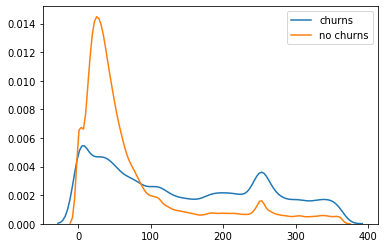

In [13]:
import numpy as np

sns.kdeplot(churns['FREC_DIARIA'],label='churns')
sns.kdeplot(no_churns['FREC_DIARIA'],label='no churns')

In [14]:
churns.TICKET_PROMEDIO

4         2312.627117
5           33.813559
7          109.322033
10          36.355932
12         118.177965
             ...     
638660     338.135593
638664      67.711864
638666      93.096044
638668      17.737288
638672      59.237288
Name: TICKET_PROMEDIO, Length: 303661, dtype: float64

### DEVOLUCIONES (¿tendrá que ver con CHURN?) 

In [15]:
#Los que se fugan devuelven pocas veces... 
pd.crosstab(train.loc[train['DEVOLUCIONES'] > 0,'DEVOLUCIONES'],train.loc[train['DEVOLUCIONES']>0,'CHURN']).sort_values(0.0,ascending=False).head(15)

CHURN,0.0,1.0
DEVOLUCIONES,,
1,47291,17975
2,13699,1997
3,5333,390
4,2458,99
5,1241,38
6,677,17
7,426,3
8,231,4
9,182,4


In [16]:
dev_totales_disc = {'no_dev': [0],'poca_dev':range(1,7),
                    'moderada_dev':range(7,12),'alta_dev':range(12,24),'muy_alta_dev':range(24,36),
                   'exagerada_dev':range(36,10000)}

train['devoluciones_discreto'] = train['DEVOLUCIONES'].apply(lambda x:
                                                      next((k for k,v in dev_totales_disc.items() if round(x) in v), 'ERROR'))

test['devoluciones_discreto'] = test['DEVOLUCIONES'].apply(lambda x:
                                                    next((k for k,v in dev_totales_disc.items() if round(x) in v),'ERROR'))

In [17]:
### Ahora ya puedo ver mejor una tabla cruzada o agrupada.
train.loc[train['DEVOLUCIONES']== 0,'devoluciones_discreto'] = 'no_dev'
test.loc[test['DEVOLUCIONES']== 0,'devoluciones_discreto'] = 'no_dev'

train.groupby('devoluciones_discreto')['CONTRI'].agg({'MEAN':'mean','STD':'std','SIZE':'size'})

,MEAN,STD,SIZE
devoluciones_discreto,,,
alta_dev,493.384318,2637.668635,264
exagerada_dev,1170.548421,1823.552842,19
moderada_dev,707.243220,1852.617024,1062
muy_alta_dev,1102.292069,2704.074629,29
no_dev,92.881012,240.045958,546084
poca_dev,282.847583,566.822999,91215


In [18]:
train[train['DEVOLUCIONES'] == 0]

,DIAS_COMPRANDO,TRANSACCIONES,DEVOLUCIONES,TRX_TV,TRX_TF,VALOR_TOTAL,CONTRI,TRX_CON_TR,TRX_CON_EFX,TRX_CON_OTB,FREC_DIARIA,GENERO,EDAD,SEGMENTO,TIENE_TR,SEGMENTO_RFM,NUM_CATEGORIAS,TRX_BLANDOS,TRX_HOME,TRX_PROPIAS,TRX_TERCERAS,TRX_ANTES_5PM,TRX_DESPUES_5PM,TRX_DSCTO,TRX_LUN_JUE,TRX_VIE_DOM,TRX_NAVIDAD,TRX_MAMA,TRX_PAPA,TRX_CYBERS,TRX_DDS,TRX_BTS,TRX_LIQ01,TRX_LIQ02,TRX_CUPONES,UNID_PROD,FR_TIENDA_FAVORITA,TIENDA_FAVORITA,DESV_TICKET,CATEGORIA_FAVORITA,CONTACTABILIDAD,CONSENTIMIENTO,PERIODO_RETENCION,TICKET_PROMEDIO,CHURN,valor_total_discreto,devoluciones_discreto
0,2,2,0,0,2,253.728809,89.12,0,0,2,49.50,M,50.0,NaN,NO,R3. HABITUAL,3,10,0,0,10,0,2,1,0,2,1,0,0,0,0,1,0,0,2,5.000000,0,SIN TDA,25.508475,HOMBRE,NO,NaN,8553600.0,126.864404,0.0,up_int,no_dev
1,1,1,0,0,1,59.237288,24.79,0,1,0,253.00,NaN,0.0,PABLOMART,NO,R5. NO FIEL,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1.000000,1,PIURA I,0.000000,MUJER,NO,NaN,0.0,59.237288,0.0,bajo,no_dev
3,5,5,0,0,5,328.559319,104.15,0,3,2,29.80,F,50.0,PABLOMART,NO,R3. HABITUAL,4,5,0,2,3,0,5,0,3,2,0,0,1,1,0,3,0,0,2,1.000000,3,SAN BORJA,62.926536,CALZADO,NO,NaN,12873600.0,65.711864,0.0,alto,no_dev
4,1,1,0,0,1,2312.627117,323.34,0,1,0,201.00,F,49.0,PABLOMART,NO,R3. HABITUAL,1,0,5,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,5.000000,1,JOCKEY PLAZA,0.000000,ELECTROHOGAR,NO,NaN,0.0,2312.627117,1.0,muy_alto,no_dev
5,1,1,0,0,1,33.813559,16.38,0,1,0,267.00,M,57.0,PABLOMART,NO,R5. NO FIEL,1,1,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1.000000,1,SALAVERRY,0.000000,MUJER,NO,NaN,0.0,33.813559,1.0,muy bajo,no_dev
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
638667,8,12,0,0,12,914.669477,212.01,10,1,0,37.25,F,57.0,PABLOMART,SI,R2. PREMIUM,7,22,0,12,10,7,5,7,4,8,1,1,0,6,3,1,0,0,11,1.833333,0,SIN TDA,49.922288,CALZADO,SI,SI,25747200.0,76.222456,0.0,alto,no_dev
638668,1,1,0,0,1,17.737288,10.94,0,1,0,328.00,F,56.0,PABLOMART,NO,R5. NO FIEL,1,1,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1.000000,1,JIRON DE LA UNIÓN,0.000000,MUJER,NO,NaN,0.0,17.737288,1.0,muy bajo,no_dev
638669,2,2,0,1,1,2486.525422,-470.23,1,0,1,28.00,F,58.0,PABLOMART,NO,R2. PREMIUM,3,1,2,0,1,2,0,0,0,2,1,0,0,0,0,0,0,0,1,2.000000,0,SIN TDA,1183.983050,HOMBRE,SI,NaN,4838400.0,1243.262711,0.0,muy_alto,no_dev
638671,5,8,0,0,8,1481.194902,441.03,8,0,0,60.00,F,57.0,BRONZE,NO,R2. PREMIUM,5,31,2,23,8,3,5,5,2,6,2,0,0,4,1,0,0,0,3,4.125000,8,JOCKEY PLAZA,148.111369,INFANTIL,SI,SI,25920000.0,185.149363,0.0,muy_alto,no_dev


### Los que no compran nada en Mamá, papá, cyber, liq y school.. ¿Tienen que ver con Churn? ¿Qué edad tienen? 

- La idea primera es: ver por cada fila, si todas las columnas tienen 0 transacciones. Si es así, pondremos el valor de la columna 'no_trx' como 1 si es que no tienen ninguna transacción. Y como 0, si es que tiene al menos una transacción. 

In [19]:
# Voy a comparar las columnas de interés
compras_dias = train[['TRX_MAMA','TRX_PAPA','TRX_CYBERS','TRX_DDS','TRX_BTS','TRX_NAVIDAD','TRX_LIQ01','TRX_LIQ02','CHURN']]
compras_dias['no_trx'] = np.where((compras_dias.iloc[:,:8] == 0).all(1),1,0)
compras_dias.head(6)

,TRX_MAMA,TRX_PAPA,TRX_CYBERS,TRX_DDS,TRX_BTS,TRX_NAVIDAD,TRX_LIQ01,TRX_LIQ02,CHURN,no_trx
0,0,0,0,0,1,1,0,0,0.0,0
1,0,0,0,0,0,1,0,0,0.0,0
2,8,3,7,1,4,3,2,1,0.0,0
3,0,1,1,0,3,0,0,0,0.0,0
4,0,0,0,0,1,0,0,0,1.0,0
5,0,0,0,0,0,1,0,0,1.0,0


In [20]:
corr = compras_dias.corr('pearson')
corr

,TRX_MAMA,TRX_PAPA,TRX_CYBERS,TRX_DDS,TRX_BTS,TRX_NAVIDAD,TRX_LIQ01,TRX_LIQ02,CHURN,no_trx
TRX_MAMA,1.000000,0.509178,0.567668,0.303475,0.494103,0.443234,0.397973,0.464768,-0.196631,-0.067380
TRX_PAPA,0.509178,1.000000,0.600227,0.304296,0.505943,0.456621,0.401629,0.511504,-0.194743,-0.063980
TRX_CYBERS,0.567668,0.600227,1.000000,0.398515,0.640319,0.596141,0.518595,0.606545,-0.229732,-0.082104
TRX_DDS,0.303475,0.304296,0.398515,1.000000,0.365564,0.369804,0.341103,0.307723,-0.160798,-0.062287
TRX_BTS,0.494103,0.505943,0.640319,0.365564,1.000000,0.526930,0.508193,0.510491,-0.198184,-0.076059
TRX_NAVIDAD,0.443234,0.456621,0.596141,0.369804,0.526930,1.000000,0.473451,0.490520,-0.196372,-0.073622
TRX_LIQ01,0.397973,0.401629,0.518595,0.341103,0.508193,0.473451,1.000000,0.400662,-0.174077,-0.067721
TRX_LIQ02,0.464768,0.511504,0.606545,0.307723,0.510491,0.490520,0.400662,1.000000,-0.164089,-0.054813
CHURN,-0.196631,-0.194743,-0.229732,-0.160798,-0.198184,-0.196372,-0.174077,-0.164089,1.000000,0.101852
no_trx,-0.067380,-0.063980,-0.082104,-0.062287,-0.076059,-0.073622,-0.067721,-0.054813,0.101852,1.000000


In [21]:
# Sacamos correlaciones, para ver algún patrón

## COMPARAREMOS DOS TIPOS DE CORRELACIONES: PEARSON (LINEAL) Y KENDALL (No paramétrica)
corr2 = compras_dias.corr('spearman')
#corr2

Las variables más correlacionadas con CHURN son los cybers, back to school, papa (kendall - relacion no paramétrica) y navidad. Pero antes **DETECTAREMOS OUTLIERS** 


**NO HAY RELACIONES VISIBLES** 

In [22]:
#Dropearemos outliers porque hay muchos. VAMOS A ANALIZARLOS.
compras_dias['suma_compras'] = compras_dias.iloc[:,:8].sum(axis=1)
idx_to_drop = compras_dias[(compras_dias['suma_compras']>120)].index

In [23]:
compras_dias.loc[(compras_dias['TRX_LIQ01'] > 0) & (compras_dias['TRX_LIQ02'] == 0) ,'CHURN'].value_counts()

0.0    55697
1.0    31610
Name: CHURN, dtype: int64

In [24]:
#sns.scatterplot(x='TRX_BTS',y='TRX_CYBERS',data=compras_dias.drop(idx_to_drop,axis=0),hue='CHURN')

In [25]:
#sns.scatterplot(x='TRX_PAPA',y='TRX_NAVIDAD',data=compras_dias.drop(idx_to_drop,axis=0), hue='CHURN')

In [26]:
# Podemos interpretar esta tabla como una pequeña matrix de confusión para nuestra variable creada. 
compras_dias.groupby('no_trx')['CHURN'].value_counts()
# De los que no tuvieron ninguna transacción en los campos especificados 99 mil se fueron. Lo interesante es ver
# que los que SI tuvieron transacciones (no_trx = 0) hay 28 mil y 20 mil. 

no_trx  CHURN
0       0.0      327696
        1.0      284737
1       1.0       18924
        0.0        7316
Name: CHURN, dtype: int64

#### Se hará una **combinatoria de suma de columnas para luego decidir cuál es la mejor combinación...** (la que explica mejor al CHURN)  

In [27]:
# Genero mi lista de indexes de suma 
import itertools
A_pair = list(itertools.combinations('01234567',2))
A_tri = list(itertools.combinations('01234567',3))
A_quat = list(itertools.combinations('01234567',4))

In [28]:
for pair in A_pair:
    compras_dias['{}+{}'.format(
        compras_dias.iloc[:1,int(pair[0])].name,
        compras_dias.iloc[:1,int(pair[1])].name
        )] = compras_dias.iloc[:,int(pair[0])] + compras_dias.iloc[:, int(pair[1])]

In [29]:
for tri in A_tri:
    compras_dias['{}+{}+{}'.format(
    compras_dias.iloc[:1, int(tri[0])].name,
    compras_dias.iloc[:1, int(tri[1])].name,
    compras_dias.iloc[:1, int(tri[2])].name)] = compras_dias.iloc[:, [int(tri[0]),int(tri[1]),int(tri[2])]].sum(axis=1)

In [30]:
for tri in A_quat:
    compras_dias['{}+{}+{}+{}'.format(
    compras_dias.iloc[:1, int(tri[0])].name,
    compras_dias.iloc[:1, int(tri[1])].name,
    compras_dias.iloc[:1, int(tri[2])].name,
    compras_dias.iloc[:1, int(tri[3])].name)] = compras_dias.iloc[:, [int(tri[0]),int(tri[1]),int(tri[2]),int(tri[3])]].sum(axis=1)

Ahora procederemos a analizar las correlaciones. Es así como podremos ver qué combinación de variables podríamos hacer.

In [31]:
print(train.shape , compras_dias.shape)

(638673, 47) (638673, 165)


In [32]:
compras_dias = compras_dias.join(train['TRANSACCIONES'])

In [33]:
from scipy.stats import pearsonr, spearmanr, spearmanr

columnas = [*compras_dias.columns]
columnas.remove('CHURN')

d_ = {}
for col in columnas:
    pearson = pearsonr(compras_dias[col], compras_dias['CHURN'])
    kendall = spearmanr(compras_dias[col], compras_dias['CHURN'])
    d_[col] = [pearson[0],
               pearson[1],
               kendall[0],
               kendall[1]]

In [34]:
resultados_corr_comb = pd.DataFrame(data=d_).T.sort_values(0.0)
resultados_corr_comb.columns = ['pearson','p-val.pearson','spearman','p-val.spearman']
resultados_corr_comb.head(25)

,pearson,p-val.pearson,spearman,p-val.spearman
TRANSACCIONES,-0.262492,0.0,-0.531268,0.0
suma_compras,-0.259327,0.0,-0.516976,0.0
TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_NAVIDAD,-0.256354,0.0,-0.403160,0.0
TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_DDS,-0.256328,0.0,-0.399174,0.0
TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_LIQ01,-0.255599,0.0,-0.389349,0.0
TRX_PAPA+TRX_CYBERS+TRX_DDS+TRX_NAVIDAD,-0.254812,0.0,-0.406629,0.0
TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_NAVIDAD,-0.254693,0.0,-0.418118,0.0
TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_BTS,-0.254378,0.0,-0.406524,0.0
TRX_PAPA+TRX_CYBERS+TRX_DDS+TRX_LIQ01,-0.253855,0.0,-0.393197,0.0
TRX_MAMA+TRX_CYBERS+TRX_NAVIDAD+TRX_LIQ01,-0.253369,0.0,-0.408669,0.0


In [35]:
mejores_cols = [*resultados_corr_comb[:10].index]
mejores_cols = mejores_cols + [*resultados_corr_comb.sort_values('spearman')[:10].index]
mejores_cols = list(set(mejores_cols))

In [36]:
print(train.shape, compras_dias.shape) 

(638673, 47) (638673, 166)


In [37]:
mejores_cols.remove('TRANSACCIONES')
train = train.join(compras_dias[mejores_cols])

In [38]:
compras_test = test[['TRX_MAMA','TRX_PAPA','TRX_CYBERS','TRX_DDS','TRX_BTS','TRX_NAVIDAD','TRX_LIQ01','TRX_LIQ02']]

for tri in A_quat:
    compras_test['{}+{}+{}+{}'.format(
    compras_test.iloc[:1, int(tri[0])].name,
    compras_test.iloc[:1, int(tri[1])].name,
    compras_test.iloc[:1, int(tri[2])].name,
    compras_test.iloc[:1, int(tri[3])].name)] = compras_test.iloc[:, [int(tri[0]),int(tri[1]),int(tri[2]),int(tri[3])]].sum(axis=1)

In [39]:
compras_test['suma_compras'] = compras_test.iloc[:,:8].sum(axis=1)

In [40]:
print(test.shape, compras_test.shape)
test = test.join(compras_test[mejores_cols])
print('DESPUES',test.shape, compras_test.shape)

(159669, 47) (159669, 79)
DESPUES (159669, 64) (159669, 79)


In [41]:
compras_dias2 = compras_dias[mejores_cols].div(compras_dias['TRANSACCIONES'],axis=0)
for col in [*compras_dias2.columns]:
    compras_dias2[col].fillna(0, inplace=True)
compras_dias2 = compras_dias2.join(compras_dias['CHURN'])
for col in mejores_cols:
    pearson = pearsonr(compras_dias2[col], compras_dias2['CHURN'])
    kendall = spearmanr(compras_dias2[col], compras_dias2['CHURN'])
    d_[col] = [pearson[0],
               pearson[1],
               kendall[0],
               kendall[1]]

resultados_corr_comb_tr = pd.DataFrame(data=d_).T.sort_values(0.0)
resultados_corr_comb_tr.columns = ['pearson','p-val.pearson','spearman','p-val.kendall']
resultados_corr_comb_tr

,pearson,p-val.pearson,spearman,p-val.kendall
TRANSACCIONES,-0.262492,0.000000,-0.531268,0.000000e+00
TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_LIQ01,-0.253264,0.000000,-0.404851,0.000000e+00
TRX_PAPA+TRX_CYBERS+TRX_DDS+TRX_BTS,-0.252858,0.000000,-0.410194,0.000000e+00
TRX_MAMA+TRX_CYBERS+TRX_DDS,-0.252098,0.000000,-0.369393,0.000000e+00
TRX_CYBERS+TRX_DDS+TRX_BTS+TRX_NAVIDAD,-0.252045,0.000000,-0.413739,0.000000e+00
...,...,...,...,...
TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_LIQ01,-0.001133,0.365304,-0.021526,2.447439e-66
TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_NAVIDAD,-0.001016,0.416721,0.021054,1.538909e-63
TRX_MAMA+TRX_CYBERS+TRX_BTS+TRX_NAVIDAD,0.002313,0.064590,0.073768,0.000000e+00
TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_BTS,0.003551,0.004544,0.026300,4.142748e-98


In [42]:
resultados_corr_comb_tr.sort_values('spearman').tail(35)

,pearson,p-val.pearson,spearman,p-val.kendall
TRX_PAPA+TRX_LIQ01,-0.221062,0.000000e+00,-0.289757,0.000000e+00
TRX_NAVIDAD+TRX_LIQ01,-0.216418,0.000000e+00,-0.287214,0.000000e+00
TRX_DDS+TRX_BTS,-0.219626,0.000000e+00,-0.285408,0.000000e+00
TRX_LIQ01+TRX_LIQ02,-0.200712,0.000000e+00,-0.283461,0.000000e+00
TRX_MAMA+TRX_LIQ01,-0.222451,0.000000e+00,-0.283123,0.000000e+00
TRX_PAPA+TRX_DDS,-0.221843,0.000000e+00,-0.282400,0.000000e+00
TRX_DDS+TRX_NAVIDAD,-0.217781,0.000000e+00,-0.279551,0.000000e+00
TRX_MAMA+TRX_DDS,-0.222959,0.000000e+00,-0.275094,0.000000e+00
TRX_DDS+TRX_LIQ02,-0.200140,0.000000e+00,-0.274285,0.000000e+00
TRX_BTS,-0.198184,0.000000e+00,-0.257153,0.000000e+00


### Transacciones con descuento:

- **CRUZAR TRANSACCIONES CON DSCTO Y CONTRIBUCIONES** 

El siguiente resultado destaca que a lo mejor **¿los clientes que fugan no están enterados de los dsctos?** Es decir, compran o no compran con dscto?

- Suele haber las mismas cantidades de transacciones con descuentos en general... 

- **PERO** los no_churn han hecho mucho más transacciones con descuento que los churn!!!!!!!! 

In [43]:
print('De los churn, en total hay',churns['TRX_DSCTO'].count(),'que han hecho trx con dscto')
print('De los nochurn, en total hay',no_churns['TRX_DSCTO'].count(),'que han hecho trx con dscto')

print('De los churn, en total hay',churns['TRX_DSCTO'].sum()/train['TRX_DSCTO'].sum(),'que han hecho trx con dscto')
print('De los nochurn, en total hay',no_churns['TRX_DSCTO'].sum()/train['TRX_DSCTO'].sum(),'que han hecho trx con dscto')

De los churn, en total hay 303661 que han hecho trx con dscto
De los nochurn, en total hay 335012 que han hecho trx con dscto
De los churn, en total hay 0.13734446158254435 que han hecho trx con dscto
De los nochurn, en total hay 0.8626555384174557 que han hecho trx con dscto


In [44]:
#El 55% de los clientes no ha hecho transacciones con descuento.

trx_dscto = pd.crosstab(train['TRX_DSCTO'],train['CHURN'])
trx_dscto.reset_index(inplace=True)

In [45]:
trx_dscto

CHURN,TRX_DSCTO,0.0,1.0
0,0,136209,219876
1,1,79184,68402
2,2,37171,9627
3,3,21969,2985
4,4,14278,1214
...,...,...,...
99,180,1,0
100,199,1,0
101,204,1,0
102,296,1,0


In [46]:
print(pearsonr(train['TRX_DSCTO'],train['CHURN']))
print(spearmanr(train['TRX_DSCTO'],train['CHURN']))

(-0.2863627130095684, 0.0)
SpearmanrResult(correlation=-0.3771873803578388, pvalue=0.0)


#### PERIODO DE RETENCION:  LA CANTIDAD DE DIAS QUE PASARON ENTRE LA PRIMERA Y ULTIMA COMPRA

- Después de un pequeño análisis, **se asumirá que 86400 es el tiempo en segundos que tiene un día. Por eso, se dividirá por 86400 a toda la variable.**

In [47]:
#OJO: Correr solo una vez
train['PERIODO_RETENCION'] = train['PERIODO_RETENCION']/86400 

In [48]:
train[train['PERIODO_RETENCION']> train['PERIODO_RETENCION'].quantile(.51)].SEGMENTO.isna().sum()

39362

In [49]:
pd.cut(train['PERIODO_RETENCION'].drop(train[train['PERIODO_RETENCION']==0].index,axis=0),14).value_counts()

(0.637, 26.929]       31655
(234.357, 260.286]    26515
(312.143, 338.071]    25691
(286.214, 312.143]    25657
(208.429, 234.357]    24963
(260.286, 286.214]    24886
(182.5, 208.429]      21570
(156.571, 182.5]      20327
(130.643, 156.571]    19308
(26.929, 52.857]      18994
(52.857, 78.786]      18419
(78.786, 104.714]     18374
(104.714, 130.643]    18212
(338.071, 364.0]      16349
Name: PERIODO_RETENCION, dtype: int64

In [50]:
[*range(0,366,27)]
bins = [0,27, 54, 81, 108, 135, 162, 189, 216, 243, 270, 297, 324, 351]
names = ['<27','27-54','54-81','81-108','108-135','135-162','162-189','189-216',
         '216-243','243-270','270-297','297-324','324-351','351+']

d = dict(enumerate(names,1))

train['retencion_range'] = np.vectorize(d.get)(np.digitize(train['PERIODO_RETENCION'],bins))

In [51]:
test['retencion_range'] = np.vectorize(d.get)(np.digitize(test['PERIODO_RETENCION'],bins))

In [52]:
train.groupby('retencion_range')['CHURN'].sum()

retencion_range
108-135      5502.0
135-162      5322.0
162-189      4918.0
189-216      4744.0
216-243      4372.0
243-270      3521.0
27-54        7341.0
270-297      2631.0
297-324      2006.0
324-351      1091.0
351+          172.0
54-81        6738.0
81-108       6314.0
<27        248989.0
Name: CHURN, dtype: float64

#### Inferimos la frecuencia total de compra y la frecuencia de transacciones por periodo de retencion

In [53]:
# Freq de trx / retencion = trx tienda virtual +  trx tienda fisica
train['freq_trx_retencion']= train[['TRX_TV','TRX_TF']].sum(axis=1) / train['PERIODO_RETENCION']
test['freq_trx_retencion']= test[['TRX_TV','TRX_TF']].sum(axis=1) / test['PERIODO_RETENCION']

In [54]:
train['freq_trx_retencion'].replace([np.inf, -np.inf], 0,inplace=True)
test['freq_trx_retencion'].replace([np.inf, -np.inf],0, inplace=True)

In [55]:
# La correlación de Kendall Tau me da que se tiene un 40% de correlación
# sin embargo, la de pearson me dice que solo hay un 2.9%
spearmanr(train['freq_trx_retencion'],train['CHURN'])

SpearmanrResult(correlation=-0.45749681289240784, pvalue=0.0)

In [56]:
train[train['freq_trx_retencion'] == train['freq_trx_retencion'].max()]

,DIAS_COMPRANDO,TRANSACCIONES,DEVOLUCIONES,TRX_TV,TRX_TF,VALOR_TOTAL,CONTRI,TRX_CON_TR,TRX_CON_EFX,TRX_CON_OTB,FREC_DIARIA,GENERO,EDAD,SEGMENTO,TIENE_TR,SEGMENTO_RFM,NUM_CATEGORIAS,TRX_BLANDOS,TRX_HOME,TRX_PROPIAS,TRX_TERCERAS,TRX_ANTES_5PM,TRX_DESPUES_5PM,TRX_DSCTO,TRX_LUN_JUE,TRX_VIE_DOM,TRX_NAVIDAD,TRX_MAMA,TRX_PAPA,TRX_CYBERS,TRX_DDS,TRX_BTS,TRX_LIQ01,TRX_LIQ02,TRX_CUPONES,UNID_PROD,FR_TIENDA_FAVORITA,TIENDA_FAVORITA,DESV_TICKET,CATEGORIA_FAVORITA,CONTACTABILIDAD,CONSENTIMIENTO,PERIODO_RETENCION,TICKET_PROMEDIO,CHURN,valor_total_discreto,devoluciones_discreto,TRX_PAPA+TRX_CYBERS+TRX_BTS+TRX_NAVIDAD,TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_NAVIDAD,TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_LIQ01,TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_BTS,TRX_PAPA+TRX_CYBERS+TRX_DDS+TRX_LIQ01,suma_compras,TRX_MAMA+TRX_CYBERS+TRX_NAVIDAD+TRX_LIQ01,TRX_CYBERS+TRX_BTS+TRX_NAVIDAD+TRX_LIQ02,TRX_PAPA+TRX_CYBERS+TRX_DDS+TRX_NAVIDAD,TRX_PAPA+TRX_CYBERS+TRX_BTS+TRX_LIQ02,TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_NAVIDAD,TRX_MAMA+TRX_CYBERS+TRX_BTS+TRX_LIQ02,TRX_PAPA+TRX_CYBERS+TRX_NAVIDAD+TRX_LIQ02,TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_DDS,TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_BTS,TRX_MAMA+TRX_CYBERS+TRX_BTS+TRX_NAVIDAD,TRX_MAMA+TRX_CYBERS+TRX_NAVIDAD+TRX_LIQ02,retencion_range,freq_trx_retencion
616316,8,129,0,0,129,4921.855848,1460.4,2,45,14,1.25,M,46.0,BRONZE,NO,R1. ELITE,8,165,7,32,37,33,96,7,12,117,0,129,0,0,0,0,0,0,28,1.333333,129,PUCALLPA,22.28966,BELLEZA,NO,NaN,10.0,38.153921,0.0,muy_alto,no_dev,0,129,129,129,0,129,129,0,0,0,129,129,0,129,129,129,129,<27,12.9


In [57]:
train['prom_valor_por_trx'] = (train['VALOR_TOTAL'] / train[['TRX_TV','TRX_TF']].sum(axis=1))
test['prom_valor_por_trx'] = test['VALOR_TOTAL'] / test[['TRX_TV','TRX_TF']].sum(axis=1)

In [58]:
train['prom_valor_por_trx'].replace([np.inf, -np.inf], 0,inplace=True)
test['prom_valor_por_trx'].replace([np.inf, -np.inf],0, inplace=True)

In [59]:
print(pearsonr(train['prom_valor_por_trx'],train['CHURN']))
print(spearmanr(train['prom_valor_por_trx'],train['CHURN']))

(-0.017209001710404098, 4.824796593837666e-43)
SpearmanrResult(correlation=-0.15899155824584152, pvalue=0.0)


In [60]:
train['prom_valor_retencion'] = train['prom_valor_por_trx'] / train['PERIODO_RETENCION']
test['prom_valor_retencion'] = test['prom_valor_por_trx'] / test['PERIODO_RETENCION']

train['prom_valor_retencion'].replace([np.inf, -np.inf], 0,inplace=True)
test['prom_valor_retencion'].replace([np.inf, -np.inf],0, inplace=True)

train['prom_valor_retencion'].fillna(0,inplace=True)
test['prom_valor_retencion'].fillna(0,inplace=True)

print(pearsonr(train['prom_valor_retencion'],train['CHURN']))
print(spearmanr(train['prom_valor_retencion'],train['CHURN']))

(0.0029569725857685565, 0.01812156118077809)
SpearmanrResult(correlation=-0.41539697107101314, pvalue=0.0)


### Ideas finales de feature engineering... 

- Hacer variable que me diga si el cliente **Ha hecho trx_con dscto o no**, además, que me categorize cuántas transacciones con dscto tiene hechas o no. Por ejemplo, 0 para los que no hicieron, 1 para los que sí hicieron solo 1 vez. 2 para los que hicieron de 2 a 7 veces.Y así sucesivamente... ¿cómo mejorar la discretización?, es decir, ¿Cómo poner las categorías de la mejor manera?

- Hacer variable que pueda **discretizar** el valor total y las contribuciones de los clientes. Usar percentile para marcar los criterios y **pensar más el problema** 

- **Hacer variable que nos diga si el cliente puso su edad o no** 

- **Probar modelo sin TDA FAVORITA** 

- Discretizar las devoluciones: Categoría 0, categoría 1 (del 1 al 6 (=)), categoría 2 (del 7 al 11), categoría 3 (del 12 al 24), categoría 4 (del 24 al 36) categoría 5 (del 35 para arriba)

- Hacer **ratio de transacciones con respecto  a sus totales** 

- Agregar los que tienen mayores correlaciones dentro del feature eng de suma. Primeros 5 de cada criterio (pearson y kendall) 

- Hacer variable de frecuencia de trx por retencion y prom_valor por retencion**LISTO**



In [61]:
train.columns

Index(['DIAS_COMPRANDO', 'TRANSACCIONES', 'DEVOLUCIONES', 'TRX_TV', 'TRX_TF',
       'VALOR_TOTAL', 'CONTRI', 'TRX_CON_TR', 'TRX_CON_EFX', 'TRX_CON_OTB',
       'FREC_DIARIA', 'GENERO', 'EDAD', 'SEGMENTO', 'TIENE_TR', 'SEGMENTO_RFM',
       'NUM_CATEGORIAS', 'TRX_BLANDOS', 'TRX_HOME', 'TRX_PROPIAS',
       'TRX_TERCERAS', 'TRX_ANTES_5PM', 'TRX_DESPUES_5PM', 'TRX_DSCTO',
       'TRX_LUN_JUE', 'TRX_VIE_DOM', 'TRX_NAVIDAD', 'TRX_MAMA', 'TRX_PAPA',
       'TRX_CYBERS', 'TRX_DDS', 'TRX_BTS', 'TRX_LIQ01', 'TRX_LIQ02',
       'TRX_CUPONES', 'UNID_PROD', 'FR_TIENDA_FAVORITA', 'TIENDA_FAVORITA',
       'DESV_TICKET', 'CATEGORIA_FAVORITA', 'CONTACTABILIDAD',
       'CONSENTIMIENTO', 'PERIODO_RETENCION', 'TICKET_PROMEDIO', 'CHURN',
       'valor_total_discreto', 'devoluciones_discreto',
       'TRX_PAPA+TRX_CYBERS+TRX_BTS+TRX_NAVIDAD',
       'TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_NAVIDAD',
       'TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_LIQ01',
       'TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_BTS',
       'TRX_PAPA+T

In [62]:
test.columns

Index(['DIAS_COMPRANDO', 'TRANSACCIONES', 'DEVOLUCIONES', 'TRX_TV', 'TRX_TF',
       'VALOR_TOTAL', 'CONTRI', 'TRX_CON_TR', 'TRX_CON_EFX', 'TRX_CON_OTB',
       'FREC_DIARIA', 'GENERO', 'EDAD', 'SEGMENTO', 'TIENE_TR', 'SEGMENTO_RFM',
       'NUM_CATEGORIAS', 'TRX_BLANDOS', 'TRX_HOME', 'TRX_PROPIAS',
       'TRX_TERCERAS', 'TRX_ANTES_5PM', 'TRX_DESPUES_5PM', 'TRX_DSCTO',
       'TRX_LUN_JUE', 'TRX_VIE_DOM', 'TRX_NAVIDAD', 'TRX_MAMA', 'TRX_PAPA',
       'TRX_CYBERS', 'TRX_DDS', 'TRX_BTS', 'TRX_LIQ01', 'TRX_LIQ02',
       'TRX_CUPONES', 'UNID_PROD', 'FR_TIENDA_FAVORITA', 'TIENDA_FAVORITA',
       'DESV_TICKET', 'CATEGORIA_FAVORITA', 'CONTACTABILIDAD',
       'CONSENTIMIENTO', 'PERIODO_RETENCION', 'TICKET_PROMEDIO', 'CHURN',
       'valor_total_discreto', 'devoluciones_discreto',
       'TRX_PAPA+TRX_CYBERS+TRX_BTS+TRX_NAVIDAD',
       'TRX_MAMA+TRX_PAPA+TRX_CYBERS+TRX_NAVIDAD',
       'TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_LIQ01',
       'TRX_MAMA+TRX_CYBERS+TRX_DDS+TRX_BTS',
       'TRX_PAPA+T

¿Los clientes que compran en tienda virtual son más propensos a fugarse?

In [63]:
print('De los churn que compran en tienda virtual, hay', churns['TRX_TV'].sum(),'que compran en TV')
print('De no -churn que compran en tienda virtual, hay', no_churns['TRX_TV'].sum(),'que compran en TV')

De los churn que compran en tienda virtual, hay 6569 que compran en TV
De no -churn que compran en tienda virtual, hay 27795 que compran en TV


In [65]:
train['var'] = train['TICKET_PROMEDIO'] / train['PERIODO_RETENCION']
train['var'].replace([np.inf, -np.inf], 0,inplace=True)
train['var'].fillna(0,inplace=True)

test['var'] = test['TICKET_PROMEDIO'] / test['PERIODO_RETENCION']
test['var'].replace([np.inf, -np.inf], 0,inplace=True)
test['var'].fillna(0,inplace=True)

print(pearsonr(train['var'],train['CHURN']))
print(spearmanr(train['var'],train['CHURN']))

(0.005846735150835703, 2.974580654650476e-06)
SpearmanrResult(correlation=-0.41555114652900804, pvalue=0.0)


In [66]:
print(train.shape,test.shape)

(638673, 69) (159669, 69)


In [ ]:
train.to_csv('train_v_01.csv',index=False)
test.to_csv('test_v_01.csv',index=False)